In [358]:
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import ndimage


In [393]:
# This notebook calibrates the experimental setup using the known wavelengths of the Hg lamp

In [359]:
# Set the horizontal limits of the spectrum image
low_limit = 250
up_limit = 800


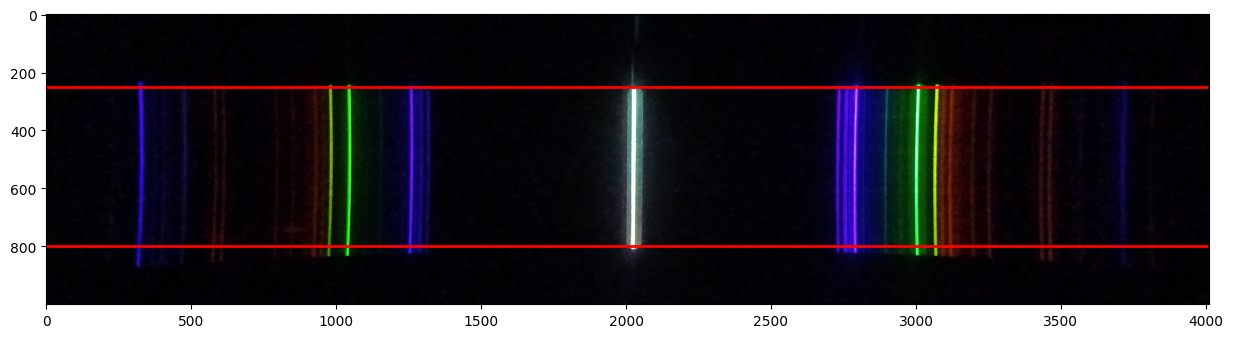

In [360]:
# Plot the spectrum image with the horizontal limits

img = image.imread('lamps_new/1.jpg')
img = ndimage.rotate(img, +0.2)
img = img[1000:2000, :, :]

plt.figure(figsize = (15, 7))
plt.imshow(img)
plt.hlines(y=[low_limit, up_limit], xmin=0,
           xmax=img.shape[1]-1, colors='red', linewidth=2)
plt.show()


In [394]:
# Filter the signal and remove the baseline
from scipy.signal import savgol_filter
from BaselineRemoval import BaselineRemoval

signal = np.linalg.norm(np.sum(img[low_limit:up_limit, :, :], axis=0), axis=1)
signal /= np.max(signal)

signal = savgol_filter(signal, 14, 7)
 
baseObj = BaselineRemoval(signal)
signal = baseObj.ZhangFit()


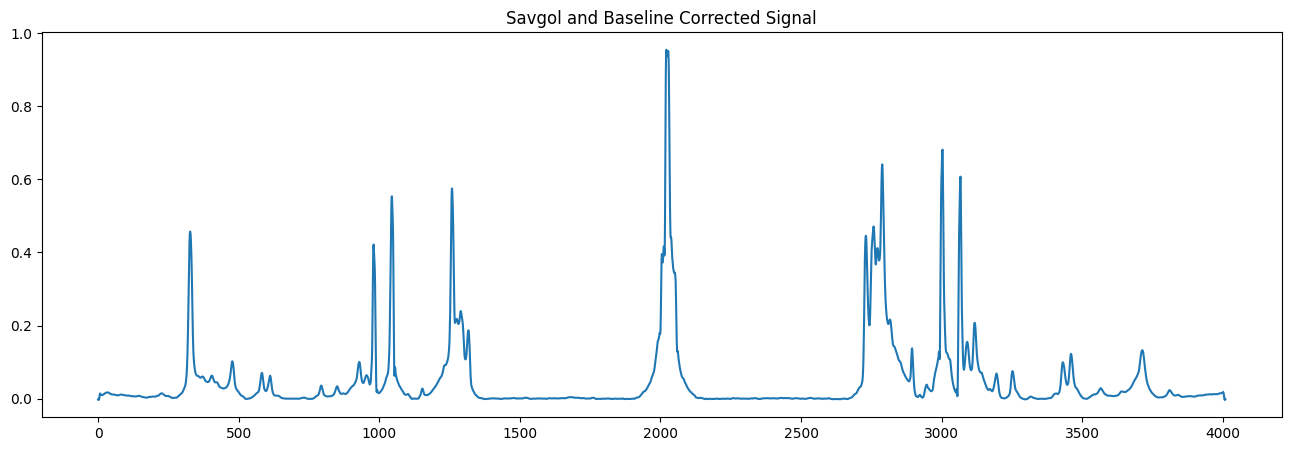

In [362]:
plt.figure(figsize = (16, 5))
plt.title("Savgol and Baseline Corrected Signal")
plt.plot(signal)

In [363]:
# Set the limits for the first order spectrum and the peakpicking threshold
small_limit = 550
large_limit = 3500
thr = 0.1
peaks, _ = find_peaks(signal, height=thr, prominence=0.05)

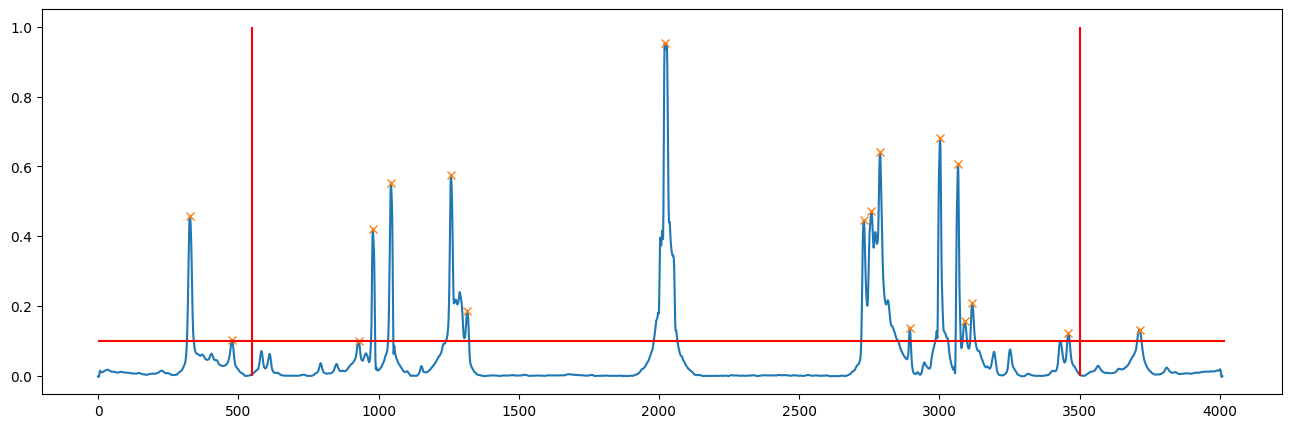

In [364]:
fig, ax = plt.subplots(figsize = (16, 5))

ax.plot(signal)
ax.plot(peaks, signal[peaks], "x")

ax.vlines(small_limit, 0, 1, "r")
ax.vlines(large_limit, 0, 1, "r")
ax.hlines(thr, 0, 4020, "r")


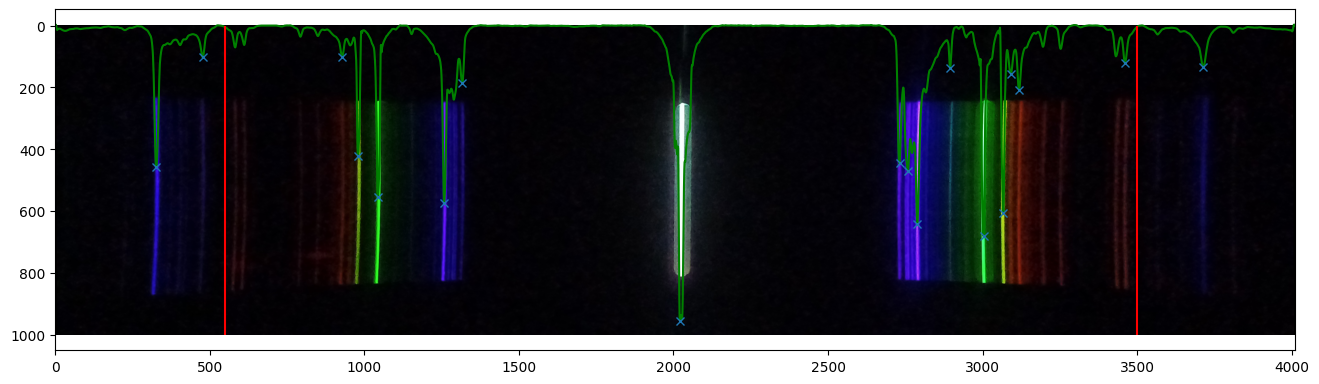

In [365]:
# Plot the spectrum and the image superimposed
fig, ax = plt.subplots(figsize = (16, 5))

ax.imshow(img)

ax.plot(1000*signal, "g")
ax.plot(peaks, 1000*signal[peaks], "x")

ax.vlines(small_limit, 0, 1000, "r")
ax.vlines(large_limit, 0, 1000, "r")


In [366]:
# Get the peaks inside the limits
good_peaks = np.array(
    [peak for peak in peaks if small_limit <= peak <= large_limit])
good_peaks

array([ 929,  980, 1045, 1259, 1317, 2021, 2731, 2758, 2789, 2895, 3003,
       3067, 3091, 3118, 3460])

In [367]:
# Search the peak closest to an estimate middle value and set it as the middle
mid_value = 2000
mid_peak = min(good_peaks, key=lambda x: abs(x - mid_value))
distances = np.abs(good_peaks-mid_peak)
mid_index = np.argmin(distances)
distances


array([1092, 1041,  976,  762,  704,    0,  710,  737,  768,  874,  982,
       1046, 1070, 1097, 1439])

In [368]:
# Get the pixel distances for the right side spectrum
right_distances = distances[mid_index+1:]
right_distances


array([ 710,  737,  768,  874,  982, 1046, 1070, 1097, 1439])

In [369]:
# Get the pixel distances for the left side spectrum
left_distances = distances[:mid_index][::-1]
left_distances


array([ 704,  762,  976, 1041, 1092])

In [370]:
# Average the left and right values if they are closer than a threshold, if not keep they as they are
mean_distances = []
i = 0
j = 0
thr = 10

while i < len(right_distances) and j < len(left_distances):
    if np.abs(right_distances[i]-left_distances[j]) < thr:
        mean_distances.append(0.5*(right_distances[i]+left_distances[j]))
        i += 1
        j += 1
    elif right_distances[i] < left_distances[j]:
        mean_distances.append(right_distances[i])
        i += 1
    else:
        mean_distances.append(left_distances[j])
        j += 1

if i < len(right_distances):
    mean_distances += list(right_distances[i:])
else:
    mean_distances += list(left_distances[i:])

mean_distances = np.array(mean_distances)


In [371]:
mean_distances


array([ 707. ,  737. ,  765. ,  874. ,  979. , 1043.5, 1070. , 1094.5,
       1439. ])

In [386]:
# Identify known lines with their frequency
good_distances = [765, 979, 1043.5]
Hg_wavelengths = np.array([435.8, 546.1, 578.0])*1e-9

Text(0, 0.5, 'd**-2')

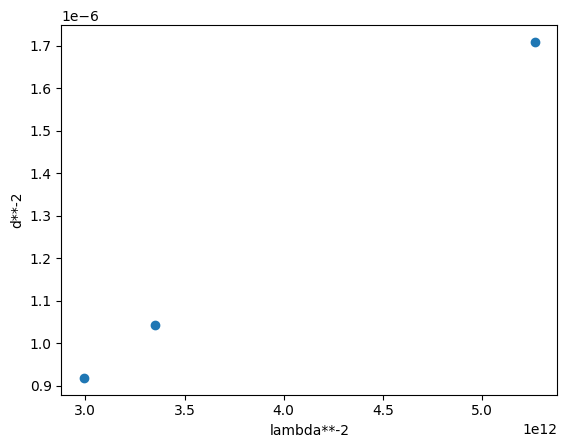

In [387]:
plt.scatter(np.power(Hg_wavelengths, -2), np.power(good_distances, -2))
plt.xlabel("lambda**-2")
plt.ylabel("d**-2")


In [388]:
# Fit using a linear model
res = np.polyfit(
    np.power(good_distances, -2), np.power(Hg_wavelengths, -2), 1)
res


array([2.87436149e+18, 3.53833799e+11])

In [389]:
# Get the grating distance (cm)
d = 1/np.sqrt(res[1])
d


1.6811262998600208e-06

In [390]:
# Get the focal length (px)
D = np.sqrt(res[0])*d
D


2850.1717788971596

In [391]:
# Fit using a polynomial model
res = np.polyfit(good_distances, Hg_wavelengths, 2)
res

array([-7.48542813e-14,  6.45966427e-10, -1.45577201e-08])

In [392]:
# Compute the expected frequencies for all found peaks
pol = np.poly1d(res)
pol(mean_distances)*1e9

array([404.72470634, 420.86101169, 435.8       , 492.83754837,
       546.1       , 578.        , 590.92569045, 602.78232667,
       759.98563658])